In [1]:
import cdsapi
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime
from data_processing import *
import os
import warnings; warnings.simplefilter('ignore')

In [2]:
#data_2016 = prepare_data2(min_wind = 30, min_steps= 20, max_steps=60, one_hot = False, secondary = False)

In [126]:
c = cdsapi.Client()

#Example of an API request
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'relative_humidity', 'temperature', 'u_component_of_wind',
            'v_component_of_wind', 'vorticity', 'geopotential'
        ],
        'pressure_level': [
            '700', '1000',
        ],
        'year': '1996',
        'month': '04',
        'day': ['06'],
        'area'          : [21.92801, 127.78100000000002, -2.12, 151.82100000000003], # North, West, South, East. Default: global
        'grid'          : [1.0, 1.0], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
        'time': [
            '18:00'
        ],
        'format': 'netcdf',
    },
    'test4.nc') #here specify filepath

2020-03-23 18:12:08,919 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-23 18:12:09,680 INFO Request is queued
2020-03-23 18:12:10,783 INFO Request is running
2020-03-23 18:12:18,223 INFO Request is completed
2020-03-23 18:12:18,225 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1585001538.595715-5625-17-a2476ebf-f69f-4ddb-8820-b8b20db9b15c.nc to test4.nc (17.5K)
2020-03-23 18:12:18,524 INFO Download rate 59.1K/s


Result(content_length=17916,content_type=application/x-netcdf,location=http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1585001538.595715-5625-17-a2476ebf-f69f-4ddb-8820-b8b20db9b15c.nc)

In [128]:
#here example to process file from netcdf format to np.array
#nc_file = 'data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_10_5_18_coord_25.1_-63.3.nc'
nc_file = 'test4.nc'
nc = netCDF4.Dataset(nc_file, mode='r')

nc.variables.keys()

lat = nc.variables['latitude'][:]
lat = np.array(lat)
lon = nc.variables['longitude'][:]
lon = np.array(lon)

time_var = nc.variables['time']
p = nc.variables['z']
dtime = netCDF4.num2date(time_var[:],time_var.units)
grid = nc.variables['u'][:]

grid = np.array(grid).squeeze(0)#reshape(grid.shape[1],grid.shape[2], grid.shape[3])

In [129]:
lat

array([21.88, 20.88, 19.88, 18.88, 17.88, 16.88, 15.88, 14.88, 13.88,
       12.88, 11.88, 10.88,  9.88,  8.88,  7.88,  6.88,  5.88,  4.88,
        3.88,  2.88,  1.88,  0.88, -0.12, -1.12, -2.12], dtype=float32)

In [78]:
grid.shape

(2, 24, 25)

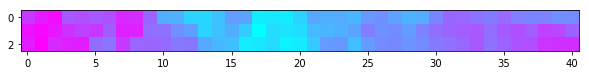

In [104]:
#Example of a plot, colors are artificial
plt.figure(figsize=(10,10))
plt.imshow(grid[1], cmap ='cool')
#plt.xticks(lon)
#plt.yticks(lat)
plt.show()

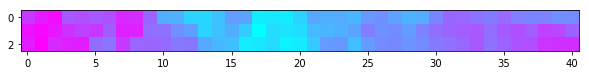

In [107]:
#Example of a plot, colors are artificial
plt.figure(figsize=(10,10))
plt.imshow(grid[1], cmap ='cool')
#plt.xticks(lon)
#plt.yticks(lat)
plt.show()

# Actual code to use

In [6]:
def process_netcdf(filepath, param):
    '''
    input: netcdf filepath and the specific corresponding parameter in str format (eg. 'z', 'u', 'v'...) 
    '''
    nc = netCDF4.Dataset(filepath, mode='r')
    nc.variables.keys()
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time_var = nc.variables['time']
    dtime = netCDF4.num2date(time_var[:],time_var.units)
    grid = nc.variables[param][:]
    #transform into np.array format and reshape something in (1,grid_size,grid_size) into (grid_size,grid_size)
    grid = np.array(grid).reshape(grid.shape[1],grid.shape[2], grid.shape[3])    
    return grid

In [7]:
#a = process_netcdf('data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_10_5_18_coord_25.1_-63.3.nc', 'u')

In [8]:
def get_storms(extraction = False, min_wind = 30, min_steps= 20, max_steps=60):
    '''
    returns an array of elements of type [datetime, lat, lon]
    set extraction to True if used for downloading data and False if used to convert netcdf files to tensor
    '''
    data = prepare_data2(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps, one_hot = False, secondary = False)
    e = data.transpose((2,0,1))
    d = e.reshape(e.shape[0]*e.shape[1],3)
    for t in d:
        try:
            t[0] = datetime.strptime(t[0], "%Y-%m-%d %H:%M:%S")
        except:
            pass
    if extraction :
        f = d.reshape(e.shape[0],e.shape[1],3)
        return f
    return d

In [9]:
def get_timestep_vision(time, lat, lon):
    '''
    given a datetime and latitute, longitude returns a processed array obtained after donwload
    '''
    filepath = get_filename(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon)
    u, v, z = process_netcdf(filepath, 'u'), process_netcdf(filepath, 'v'), process_netcdf(filepath, 'z')
    return np.array([u, v, z])

In [145]:
bad_shapes = []
times, lati, long = [], [], []
def get_storm_vision(storm, epsilon):
    '''
    given a storm (list of timesteps with time and lat/lon), returns the vision array
    '''
    l = np.zeros((len(storm), 3, 3, 25, 25))
    for i in range(len(storm)):
        time, lat, lon = storm[i]
        try :
            l[i]=get_timestep_vision(time, lat, lon)
        except:
            try :
                b = get_timestep_vision(time, lat, lon)
                print(b.shape)
                print(time, lat, lon)
                get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon, grid_size = 25, force = True, epsilon = epsilon)
                times.append(time)
                lati.append(lat)
                long.append(lon)
                bad_shapes.append(b)
            except:
                pass
    return l

In [144]:
def extract_vision(data, epsilon):
    '''
    processes all the data to get the vision array
    '''
    
    vision = []
    for storm in data:
        vision.append(get_storm_vision(storm, epsilon))
    return np.array(vision)

In [12]:
def get_filename(pressure, params, time, lat, lon):
    '''
    returns filename to save the netcdf file
    '''
    params_str = '_'.join(map(str, params))
    pressure_str = '_'.join(map(str, pressure))
    year, month, day, hour = str(time.year), str(time.month), str(time.day), str(time.hour)
    return 'data_era/'+params_str+'/eradata_'+pressure_str+'hPa'+'_'+year+'_'+month+'_'+day+'_'+hour+'_'+'coord'+'_'+str(lat)+'_'+str(lon)+'.nc'

In [13]:
#get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], times[0], lati[0], long[0], grid_size = 25)

In [141]:
def get_area(lat, lon, grid_size, e = 0.008):
    '''
    input : center of the storm, 
    output: returns a centered squared grid of size grid_size degrees
    '''
    val = grid_size // 2
    return [lat + val + e, lon - val, lat - val - e, lon + val]

In [142]:
def get_data(pressure_level, params, time, lat, lon, grid_size = 25, degbypix = 1.0, force = False, epsilon = 0.008):
    '''
    pressure_level is the the pressure level we wish to get the data.
    params has to be in format e.g: 'geopotential' or 'u_component_of_wind' or 'v_component_of_wind'
    grid_size should be odd
    '''
    if not os.path.exists(get_filename(pressure_level, params, time, lat, lon)) or force:
        c = cdsapi.Client()
        year, month, day, hour = str(time.year), str(time.month), str(time.day), str(time.hour)
    
        c.retrieve('reanalysis-era5-pressure-levels', {
            'variable'      : params,
            'pressure_level': pressure_level,
            'product_type'  : 'reanalysis',
            'year'          : year,
            'month'         : month,
            'day'           : day,
            'area'          : get_area(lat, lon, grid_size, epsilon), # North, West, South, East. Default: global
            'grid'          : [degbypix, degbypix], # Latitude/longitude grid: east-west (longitude) and north-south resolution (latitude). Default: 0.25 x 0.25
            'time'          : hour,
            'format'        : 'netcdf' # Supported format: grib and netcdf. Default: grib
        }, get_filename(pressure_level, params, time, lat, lon))
    else:
        print("Already downloaded", get_filename(pressure_level, params, time, lat, lon))

In [16]:
#Example
#get_data('700', 'u_component_of_wind', datetime.now(), 55.4467, 177.3241, 11)

In [17]:
def download_all(data):
    for storm in data:
        time, lat, lon = storm[0], storm[1], storm[2]
        get_data(['700', '500', '225'], 'geopotential', time, lat, lon, grid_size = 25)
        get_data(['700', '500', '225'], 'u_component_of_wind', time, lat, lon, grid_size = 25)
        get_data(['700', '500', '225'], 'v_component_of_wind', time, lat, lon, grid_size = 25)
        #get_data('700', 'vorticity', time, lat, lon, grid_size = 11, degbypix=1.0)
        #get_data('1000', 'relative_humidity', time, lat, lon, grid_size = 11, degbypix=1.0)
    print("Download complete.")

In [18]:
def download_all2(data):
    i = 0
    for storm in data:
        for t in storm:
            time, lat, lon = t[0], t[1], t[2]
            try:
                get_data(['700', '500', '225'], ['geopotential', 'u_component_of_wind', 'v_component_of_wind'], time, lat, lon, grid_size = 25)
            except:
                print("False request.")
        i+=1
        print("Storm ", i, " completed.")
    print("Download complete.")

In [19]:
data = get_storms(extraction=True, min_wind = 30, min_steps= 20, max_steps=60)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 182 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [92]:
min(data[:,:,2].reshape(-1))

-179.75

In [94]:
get_area(10, -179.75, 25)

[22.008, -191.758, -2.008, -167.742]

In [21]:
download_all2(data)

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_6_coord_3.4_-171.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_9_coord_3.5125_-171.30700000000002.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_12_coord_3.7_-171.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_15_coord_4.0275099999999995_-171.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_18_coord_4.4_-171.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_7_21_coord_4.68499_-171.063.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_8_0_coord_5.0_-171.1.nc
Already downlo

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_12_21_coord_25.2413_-35.2251.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_0_coord_25.4_-34.7.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_3_coord_25.4922_-34.1421.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_6_coord_25.6_-33.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_9_coord_25.7623_-33.0497.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_12_coord_26.0_-32.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_13_15_coord_26.2899_-31.942.nc
Already downloaded dat

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_26_21_coord_-27.3824_77.4472.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_0_coord_-27.7_76.95.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_3_coord_-27.7678_76.3731.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_6_coord_-27.7_76.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_9_coord_-27.5449_76.0779.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_12_coord_-27.45_76.35.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_1_27_15_coord_-27.5863_76.5658.nc
Already downloaded

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_6_coord_34.7_-75.7.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_9_coord_34.9224_-75.5573.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_12_coord_35.1_-75.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_15_coord_35.265_-75.215.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_18_coord_35.4_-75.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_2_21_coord_35.5148_-74.7799.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_6_3_0_coord_35.6_-74.5.nc
Already downloaded data_era/geopote

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_3_coord_16.8848_-128.608.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_6_coord_17.1_-128.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_9_coord_17.3425_-129.25.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_12_coord_17.6_-129.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_15_coord_17.8499_-129.908.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_18_coord_18.1_-130.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_8_21_coord_18.3425_-130.5.nc
Already downloaded data_era

Storm  26  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_31_12_coord_14.7_-119.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_31_15_coord_14.9001_-120.19.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_31_18_coord_15.1_-120.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_7_31_21_coord_15.3_-121.04299999999999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_1_0_coord_15.5_-121.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_1_3_coord_15.6924_-121.943.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_1_6_coord_15.9_-122.4

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_5_12_coord_18.5_-93.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_5_15_coord_18.6_-94.1225.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_5_18_coord_18.7_-94.7.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_5_21_coord_18.7954_-95.1635.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_6_0_coord_18.9_-95.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_6_2_coord_19.0_-96.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_6_3_coord_19.0087_-96.074.nc
Already downloaded data_era/geopotent

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_6_coord_29.475_133.65.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_9_coord_29.2849_133.421.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_12_coord_29.125_133.275.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_15_coord_28.9687_133.184.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_18_coord_28.85_133.175.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_21_21_coord_28.785_133.234.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_8_22_0_coord_28.75_133.35.nc
Already downloaded

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_17_0_coord_20.1_-127.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_17_3_coord_20.1502_-127.552.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_17_6_coord_20.2_-128.0.nc
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  48  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_11_12_coord_12.4_146.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_11_15_coord_12.6_145.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_11_18_coord_12.68_144.66.nc
Already downlo

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  58  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_28_12_coord_13.4_-59.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_28_15_coord_13.4854_-60.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_28_18_coord_13.6_-61.2.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_28_21_coord_13.7573_-61.8999.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_9_29_0_coord_13.9_-62.6.nc
Already downloaded data_era/ge

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_11_27_12_coord_16.8_118.25.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_11_27_15_coord_16.9725_118.352.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_11_27_18_coord_17.1_118.45.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_11_27_21_coord_17.1581_118.559.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2016_11_28_0_coord_17.175_118.675.nc
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False requ

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_15_6_coord_-51.3_170.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_15_9_coord_-51.0434_171.24.nc
Storm  84  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_16_0_coord_11.3_123.35.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_16_3_coord_11.4083_122.911.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_16_6_coord_11.6_122.45.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_16_9_coord_11.9175_121.807.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_4_16_12_coord_12.3444_120.889.nc
Al

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_17_21_coord_14.1424_-131.50799999999998.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_0_coord_14.4_-131.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_3_coord_14.65_-132.108.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_6_coord_14.9_-132.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_9_coord_15.1499_-132.65.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_12_coord_15.4_-132.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_7_18_15_coord_15.65_-133.19299999999998.nc
A

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_18_0_coord_46.7_181.0.nc
False request.
False request.
False request.
Storm  110  completed.
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_12_18_coord_24.0_-69.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_12_21_coord_24.4424_-69.7077.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_13_0_coord_24.9_-70.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_13_3_coord_25.3424_-70.3003.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_8_13_6_coord_25.8_-70.6.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hP

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_6_coord_16.4_-109.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_9_coord_16.65_-109.455.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_12_coord_16.9_-109.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_15_coord_17.15_-109.335.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_18_coord_17.4_-109.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_14_21_coord_17.6575_-109.335.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_9_15_0_coord_17.9_-109.4.nc
Already downloaded data_er

2020-03-22 18:27:07,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:27:09,044 INFO Request is completed
2020-03-22 18:27:09,046 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data6/adaptor.mars.internal-1584852292.7288544-30185-17-03085576-50dc-4d65-81df-037ac0dd52f1.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_12_0_coord_17.7923_112.962.nc (13K)
2020-03-22 18:27:09,361 INFO Download rate 41.5K/s
2020-03-22 18:27:09,499 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:27:10,174 INFO Request is queued
2020-03-22 18:27:11,271 INFO Request is running
2020-03-22 18:27:15,215 INFO Request is completed
2020-03-22 18:27:15,217 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data1/adaptor.mars.internal-1584916038.089663-31262-17-fe0eb295-bd50-4aac-a28b-005d69c4

data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_11_12_coord_17.925_114.425.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_11_15_coord_17.8825_114.045.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_11_18_coord_17.8267_113.62700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_11_21_coord_17.8167_113.27600000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_12_6_coord_17.5333_112.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_12_9_coord_17.4249_112.031.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2017_11_12_12_coord_17.3667_111.76700000

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_5_12_coord_19.8_111.4.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_5_15_coord_20.2176_111.195.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_5_18_coord_20.5_110.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_5_21_coord_20.74_110.685.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_6_0_coord_20.8_110.5.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_6_3_coord_20.5725_110.29700000000001.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_6_6_6_coord_20.3_110.2.nc
Already downloaded data_era

Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_9_15_coord_16.1925_-130.107.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_9_18_coord_16.5_-130.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_9_21_coord_16.7925_-130.058.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_10_0_coord_17.1_-130.0.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_10_3_coord_17.435_-129.95.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_10_6_coord_17.8_-129.9.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_8_10_9_coord_18.1925_-129.835.nc
Already downloaded data

2020-03-22 18:27:16,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels



Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_15_15_coord_32.177_-40.9721.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_15_18_coord_32.5_-40.3.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_15_21_coord_32.8495_-39.5798.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_16_0_coord_33.2_-38.8.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_16_3_coord_33.5144_-37.9794.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_16_6_coord_33.8_-37.1.nc
Already downloaded data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_9_16_9_coord_34.0869_-36.1728.nc
Already downloaded da

2020-03-22 18:27:17,570 INFO Request is completed
2020-03-22 18:27:17,572 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data7/adaptor.mars.internal-1584916022.8967342-3661-13-6b273351-835f-4987-8779-ca203a95ccd4.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_20_15_coord_14.9849_-105.315.nc (13K)
2020-03-22 18:27:17,956 INFO Download rate 33.9K/s  
2020-03-22 18:27:18,214 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:27:18,799 INFO Request is queued
2020-03-22 18:27:19,904 INFO Request is running
2020-03-22 18:27:23,850 INFO Request is completed
2020-03-22 18:27:23,853 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data4/adaptor.mars.internal-1584916046.6869814-22381-15-a3e1cb70-7c41-4249-9771-4821470130f5.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_20_18_coord_15.1_-105.5

2020-03-22 18:28:34,139 INFO Request is queued
2020-03-22 18:28:35,240 INFO Request is running
2020-03-22 18:28:39,181 INFO Request is completed
2020-03-22 18:28:39,183 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data3/adaptor.mars.internal-1584916122.3180597-27008-17-729acdd9-acba-405d-85a5-6947ba23fdc9.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_22_6_coord_17.9_-107.1.nc (13K)
2020-03-22 18:28:39,457 INFO Download rate 47.7K/s
2020-03-22 18:28:39,825 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:28:40,280 INFO Request is queued
2020-03-22 18:28:41,379 INFO Request is running
2020-03-22 18:28:45,335 INFO Request is completed
2020-03-22 18:28:45,338 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data2/adaptor.mars.internal-1584916128.135653-18467-3-be9ad1c7-f213-40d8-90e1-3b74fbb45af7.nc to data_era/geopotential_u_compon

2020-03-22 18:29:54,794 INFO Download rate 48.3K/s
2020-03-22 18:29:55,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:29:56,004 INFO Request is queued
2020-03-22 18:29:57,113 INFO Request is running
2020-03-22 18:30:01,063 INFO Request is completed
2020-03-22 18:30:01,065 INFO Downloading http://136.156.132.105/cache-compute-0000/cache/data7/adaptor.mars.internal-1584916204.4269109-10733-38-63f8ce33-b208-4e7f-95c9-914294ea3c80.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_23_21_coord_22.0875_-106.381.nc (13K)
2020-03-22 18:30:01,349 INFO Download rate 46.2K/s
2020-03-22 18:30:01,826 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:30:02,417 INFO Request is queued
2020-03-22 18:30:03,513 INFO Request is running
2020-03-22 18:30:07,466 INFO Request is completed
2020-03-22 18:30:07,469 INF

False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
False request.
Storm  180  completed.


2020-03-22 18:30:28,059 INFO Request is queued
2020-03-22 18:30:29,161 INFO Request is running
2020-03-22 18:30:33,114 INFO Request is completed
2020-03-22 18:30:33,116 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data2/adaptor.mars.internal-1584916235.8512986-25865-32-a367b60c-46fb-4b12-9f75-7d48274e2044.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_21_12_coord_8.4_157.6.nc (13K)
2020-03-22 18:30:33,401 INFO Download rate 46K/s
2020-03-22 18:30:33,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:30:34,554 INFO Request is queued
2020-03-22 18:30:35,664 INFO Request is running
2020-03-22 18:30:39,621 INFO Request is completed
2020-03-22 18:30:39,623 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data2/adaptor.mars.internal-1584916242.3461964-29742-13-f5cea360-ebeb-4125-8363-a84a55a33b86.nc to data_era/geopotential_u_compon

2020-03-22 18:31:49,618 INFO Download rate 46K/s
2020-03-22 18:31:49,754 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:31:50,413 INFO Request is queued
2020-03-22 18:31:51,516 INFO Request is running
2020-03-22 18:31:55,463 INFO Request is completed
2020-03-22 18:31:55,466 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data4/adaptor.mars.internal-1584916318.273237-4385-3-4f2ca514-2f59-422d-b111-a3b7f56d0ee6.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_23_3_coord_11.6799_151.092.nc (13K)
2020-03-22 18:31:55,746 INFO Download rate 46.7K/s
2020-03-22 18:31:55,895 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:31:56,547 INFO Request is queued
2020-03-22 18:31:57,650 INFO Request is running
2020-03-22 18:32:01,596 INFO Request is completed
2020-03-22 18:32:01,598 INFO Downl

2020-03-22 18:33:10,525 INFO Download rate 45.6K/s
2020-03-22 18:33:10,842 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:33:11,345 INFO Request is queued
2020-03-22 18:33:12,450 INFO Request is running
2020-03-22 18:33:16,396 INFO Request is completed
2020-03-22 18:33:16,398 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data8/adaptor.mars.internal-1584916399.2755845-32666-16-37a2e7bf-b8d6-4322-8b59-174594ec1307.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_24_18_coord_15.3_145.3.nc (13K)
2020-03-22 18:33:16,669 INFO Download rate 48.4K/s
2020-03-22 18:33:16,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:33:17,278 INFO Request is queued
2020-03-22 18:33:18,380 INFO Request is running
2020-03-22 18:33:22,337 INFO Request is completed
2020-03-22 18:33:22,338 INFO Downl

2020-03-22 18:34:32,848 INFO Download rate 46.8K/s
2020-03-22 18:34:33,349 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:34:33,827 INFO Request is queued
2020-03-22 18:34:34,928 INFO Request is running
2020-03-22 18:34:38,882 INFO Request is completed
2020-03-22 18:34:38,885 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data2/adaptor.mars.internal-1584916481.6895642-18086-36-0a142f54-5635-4e49-86dc-6c0bf5f37549.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_26_9_coord_17.0196_138.25.nc (13K)
2020-03-22 18:34:39,179 INFO Download rate 44.6K/s
2020-03-22 18:34:39,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:34:39,971 INFO Request is queued
2020-03-22 18:34:41,073 INFO Request is running
2020-03-22 18:34:45,035 INFO Request is completed
2020-03-22 18:34:45,038 INFO D

2020-03-22 18:35:56,584 INFO Download rate 47.6K/s
2020-03-22 18:35:56,699 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:35:57,158 INFO Request is queued
2020-03-22 18:35:58,263 INFO Request is running
2020-03-22 18:36:03,085 INFO Request is completed
2020-03-22 18:36:03,088 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data6/adaptor.mars.internal-1584916564.9747803-11864-11-551adae7-c42e-4107-95f9-7ddfde226cab.nc to data_era/geopotential_u_component_of_wind_v_component_of_wind/eradata_700_500_225hPa_2018_10_28_0_coord_18.0_130.1.nc (13K)
2020-03-22 18:36:03,369 INFO Download rate 46.6K/s
2020-03-22 18:36:03,887 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-03-22 18:36:04,339 INFO Request is queued
2020-03-22 18:36:05,440 INFO Request is running
2020-03-22 18:36:09,396 INFO Request is completed
2020-03-22 18:36:09,398 INFO Downlo

Storm  181  completed.
Download complete.


# OBSERVE DATA

In [149]:
vision_data = extract_vision(get_storms(extraction=True, min_wind = 30, min_steps= 20, max_steps=60), epsilon = 0.042)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 182 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [ ]:
2016-10-15 21:00:00 9.90801 139.80100000000002

In [130]:
get_area(9.90801, 139.80100000000002, 25, 0.03)

[21.938010000000002,
 127.77100000000002,
 -2.121989999999999,
 151.83100000000002]

In [23]:
print(vision_data.shape)
vision_data[0][7,0,0,:,:]

(18, 60, 3, 3, 25, 25)


array([[ 7.83490984e+00,  9.73575996e+00,  9.98219023e+00,
         9.76913073e+00,  1.00887200e+01,  1.04172937e+01,
         1.02581408e+01,  1.05045710e+01,  1.03184649e+01,
         1.05494932e+01,  1.07972070e+01,  1.10705906e+01,
         1.15750025e+01,  1.21500065e+01,  1.27673656e+01,
         1.33834413e+01,  1.40303207e+01,  1.48093997e+01,
         1.56321175e+01,  1.68142126e+01,  1.81105385e+01,
         1.91540167e+01,  1.99472141e+01,  2.06723865e+01,
         2.13398018e+01],
       [ 6.81325103e+00,  7.63340176e+00,  7.72324613e+00,
         7.82207493e+00,  8.70768370e+00,  9.39435136e+00,
         9.68698730e+00,  9.78453262e+00,  9.67800287e+00,
         9.75116185e+00,  9.53425188e+00,  8.68329737e+00,
         8.26102884e+00,  8.76415730e+00,  9.30065652e+00,
         1.00129940e+01,  1.08280108e+01,  1.14748902e+01,
         1.20973833e+01,  1.28982817e+01,  1.37697721e+01,
         1.50622475e+01,  1.67898263e+01,  1.87997732e+01,
         2.07750658e+01],
    

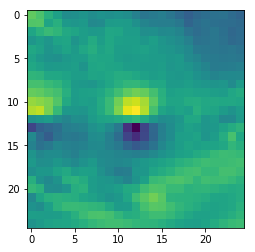

In [24]:
a = vision_data[1, 10, 0, 1]
plt.imshow(a)
plt.show()

# CNN

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# CNN for one stream : z (pressure field) : 2d data

class Net_2d_conv3_4fc(nn.Module):
    def __init__(self, dropout = 0.5):
        super(Net_2d_conv3_4fc, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv3_bn = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(in_features=256*4*4, out_features=576)
        self.fc1_bn = nn.BatchNorm1d(576)
        self.fc2 = nn.Linear(in_features=576, out_features=128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)
        self.init_weights()

    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            if isinstance(m, nn.Conv2d) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.Linear) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(1, -1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x
    
class EncoderCNN(nn.Module):
    def __init__(self, dropout = 0.5):
        super(EncoderCNN, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.init_weights()


    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            if isinstance(m, nn.Conv2d) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(1, -1)
    
        return x
    
class EncoderLinear1(nn.Module):
    def __init__(self, rnn_decoder, dropout = 0.5):
        super(EncoderLinear1, self).__init__()

        self.fc1 = nn.Linear(in_features=256*4*4, out_features=576)
        self.fc1_bn = nn.BatchNorm1d(576)
        self.fc2 = nn.Linear(in_features=576, out_features=128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)
        self.init_weights()
        self.rnn_decoder = rnn_decoder

    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.Linear) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)

    def forward(self, x):
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        if self.rnn_decoder:
            return x
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x
    
class EncoderCNNLinear1(nn.Module):
    def __init__(self, dropout = 0.5, rnn_decoder = False):
        super(EncoderCNNLinear1, self).__init__()

        self.cnn = EncoderCNN()
        self.linear = EncoderLinear1(rnn_decoder)

    def forward(self, x):
        x = self.cnn(x)
        x = self.linear(x)
        return x

In [26]:
class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0.5):
        super(DecoderGRU, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size)

    def forward(self, inputs, hidden = None):
        if hidden is None:
            hidden = self.init_hidden(self.hidden_size)
        outputs, hiddens = self.rnn(inputs.unsqueeze(0), hidden)
        return outputs, hiddens

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))
    
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_decoder = True, dropout = 0.5):
        super(EncoderDecoder, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.encoder = EncoderCNNLinear1(rnn_decoder=True)
        self.decoder = DecoderGRU(input_size, hidden_size)
        self.lastlinear = nn.Linear(hidden_size, 2)
        self.hidden = self.init_hidden(hidden_size)

    def forward(self, inputs, hidden = None):
        x = self.encoder(inputs)
        o, self.hidden = self.decoder(x, self.hidden)
        y = self.lastlinear(o)
        return y

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))

In [27]:
test = torch.Tensor(vision_data[0][0]).reshape(1, 9, 25, 25)

In [28]:
e_d = EncoderDecoder(128, 128)
e_d.eval()
e_d(test)

tensor([[[0.1390, 0.2633]]], grad_fn=<AddBackward0>)

In [29]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))




In [31]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [32]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [33]:
vision_data.shape

(18, 60, 3, 3, 25, 25)

In [ ]:
v = vision_data.reshape(18, 60, 9, 25, 25)
v = torch.Tensor(v)

In [ ]:
v[0].unsqueeze(0).shape

In [ ]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [ ]:
outputs[0][0].shape

In [ ]:
len(a[0])